*Luka Alhonen*

# Exercise 2

## 1 Non-programming Tasks

### 1.1 Learning diary

#### Reading data and synchronisation

Because of the diversity of IoT applications, data from sensors is accessed in many ways, however the three main ways of accessing sensor data are; Streaming, Polling and Event-based. These different approaches are often used in combination in IoT applications, which leads to misaligned data since sensors may take samples at different times. To solve this issue, synchronisation is applied to align samples taken at different times, as well as with inconsistent or different sampling frequencies. For example, sensor 1 has sampling frequency 50 Hz and 
sensor 2 has sampling frequency 60 Hz. Synchronisation can the be used to match the corresponding samples from sensor 1 to sensor 2. This can be performed for example by interpolation with upsampling, where the sampling rate is increased to fill in the blanks or with downsampling where the sampling rate is decreased to discard some samples.

#### Ground thruth

In order to evaluate the performance of IoT applications, one needs to be able to compare the results of the application to a fundamental truth in order to determine if the result is correct. This fundamental truth is referred to as a ground truth. One example of a ground truth is the kilogram, which today, is measured using an atomic transition frequency, the speed of light and the Planck constant. Since ground truths can be difficult to access, gold standards, meaning measurements from highly accurate devices, referred to as reference instruments, are often used instead. Gold standards or ground truths can be divided into three types; discrete labels or classes, continuous value and regions of interest. 

## 2 Programming tasks

### 2.1 Signal Synchronisation and Interpolation

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Read dataset into dataframe
df = pd.read_csv('sensors_sample.csv', header=None)

#### 1. Sample Synchronisation

To synchronise the samples I first distribute the data points in the first two columns along the lenght of the last column and fill in the gaps with NaN. This then allows me to synchronise the samples by interpolating. I then assigned a time index to the dataframe and then used the resample() function from pandas to resample the data at a frequency of 50 Hz (20 ms) and interpolate the missing values.

In [10]:
# Count the number of non-NaN values in each column
counts = df.count()

# Find the maximum count
max_count = counts.max()

# Create a new DataFrame with the same number of rows as the longest column
new_df = pd.DataFrame(index=range(max_count))

# For each column in the original DataFrame
for col in df.columns:
    # Calculate the indices where the non-NaN values should be placed
    indices = np.linspace(0, max_count-1, counts[col]).astype(int)
    # Create a new series with NaNs at all indices
    new_series = pd.Series(np.nan, index=range(max_count))
    # Place the non-NaN values at the calculated indices
    new_series[indices] = df[col].dropna().values
    # Add the new series to the new DataFrame
    new_df[col] = new_series

In [11]:
# Create time index
time_index = pd.date_range(start='00:00:00', periods=len(new_df), freq='20ms')

# Set time index
new_df.index = time_index

# Resample and interpolate
resamp_df = new_df.resample('20ms').asfreq().interpolate(method='linear')

# Reset index to make dataset look nice :)
resamp_df = resamp_df.reset_index(drop=True)
resamp_df.to_csv('out.csv')

#### 2. Plotting measurements

From the plots it's evident that after synchronisation, only column 2 (Plot 4.2) exhibits loss of accuracy (that is visible to the naked eye atleast), otherwise the signals have been interpolated well.

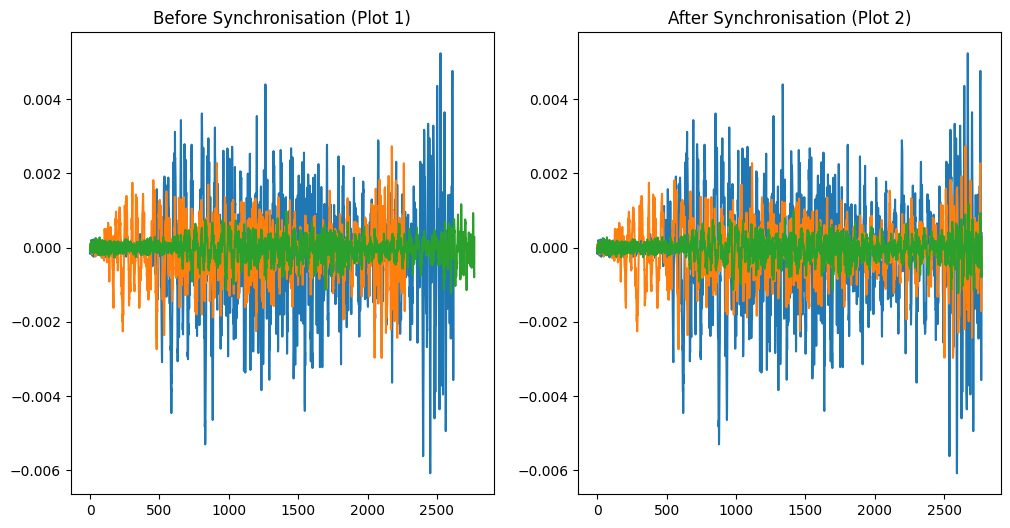

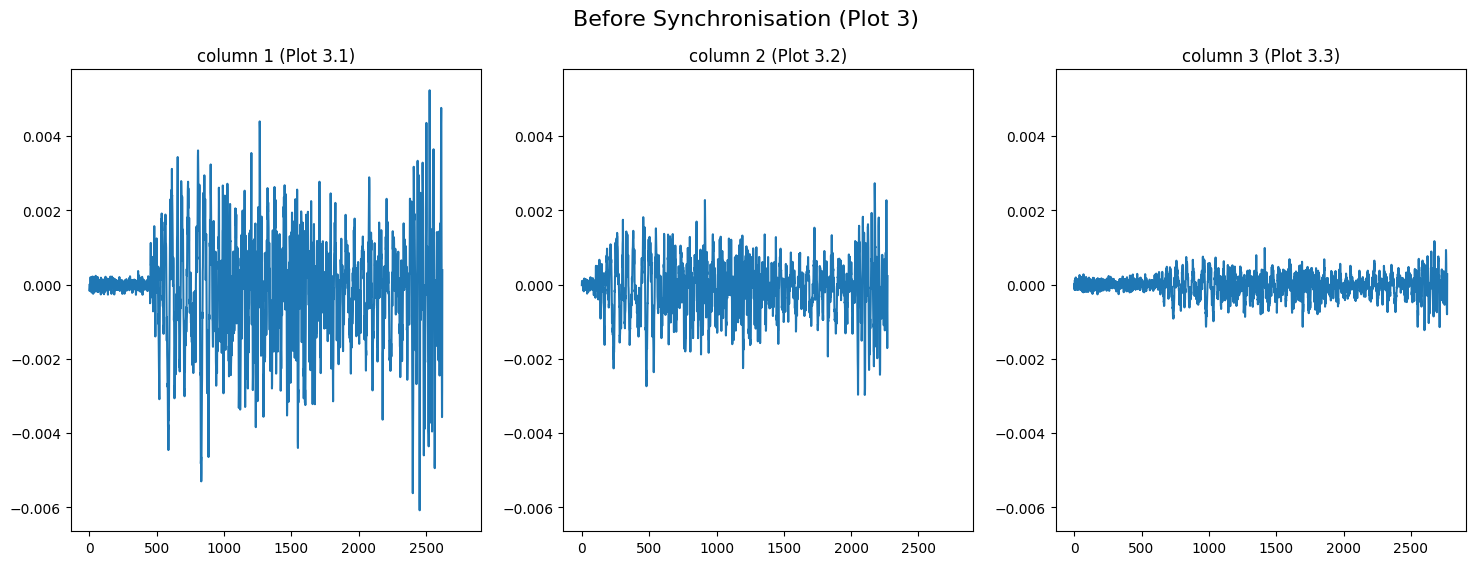

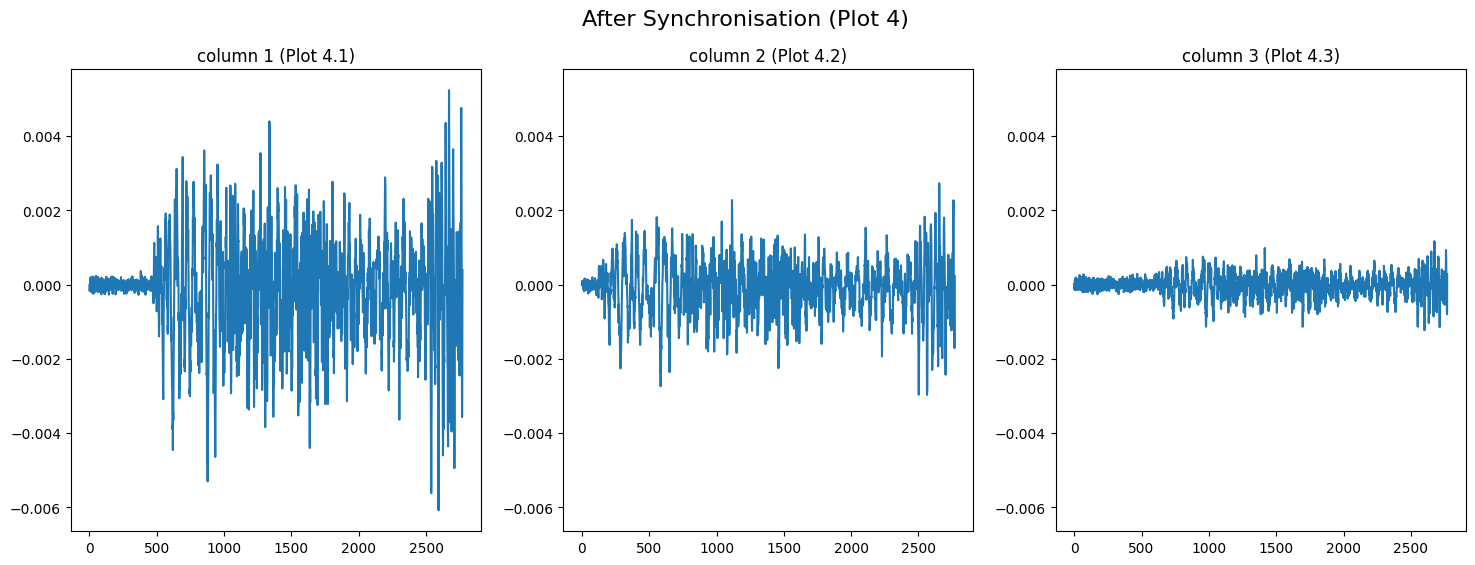

In [12]:
plt.figure(figsize=(12, 6))

# Plot before synchronisation
plt.subplot(1, 2, 1)
plt.plot(df.index, df.values)
plt.title('Before Synchronisation (Plot 1)')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

# Plot after synchronisation
plt.subplot(1, 2, 2)
plt.plot(resamp_df.index, resamp_df.values)
plt.title('After Synchronisation (Plot 2)')

# Set the same x and y limits for the second plot
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])

# Plot individual column before synchronisation
fig1, axs1 = plt.subplots(1, df.shape[1], figsize=(6 * df.shape[1], 6))
for i in range(df.shape[1]):
    axs1[i].plot(df.index, df.iloc[:, i])
    axs1[i].set_title(f'column {i+1} (Plot 3.{i+1})')
    axs1[i].set_xlim([xmin, xmax])
    axs1[i].set_ylim([ymin, ymax])
fig1.suptitle(f'Before Synchronisation (Plot 3)', fontsize=16)

# Plot individual column after synchronisation
fig2, axs2 = plt.subplots(1, resamp_df.shape[1], figsize=(6 * resamp_df.shape[1], 6))
for i in range(resamp_df.shape[1]):
    axs2[i].plot(resamp_df.index, resamp_df.iloc[:, i])
    axs2[i].set_title(f'column {i+1} (Plot 4.{i+1})')
    axs2[i].set_xlim([xmin, xmax])
    axs2[i].set_ylim([ymin, ymax])
fig2.suptitle(f'After Synchronisation (Plot 4)', fontsize=16)

plt.show()

#### 3. Interpolation

As one can see from Plot 7, interpolation with sampling rate 40 Hz seems to have the worst impact on accuracy. Other plots also exhibit loss of accuracy, but none as bad as Plot 7.

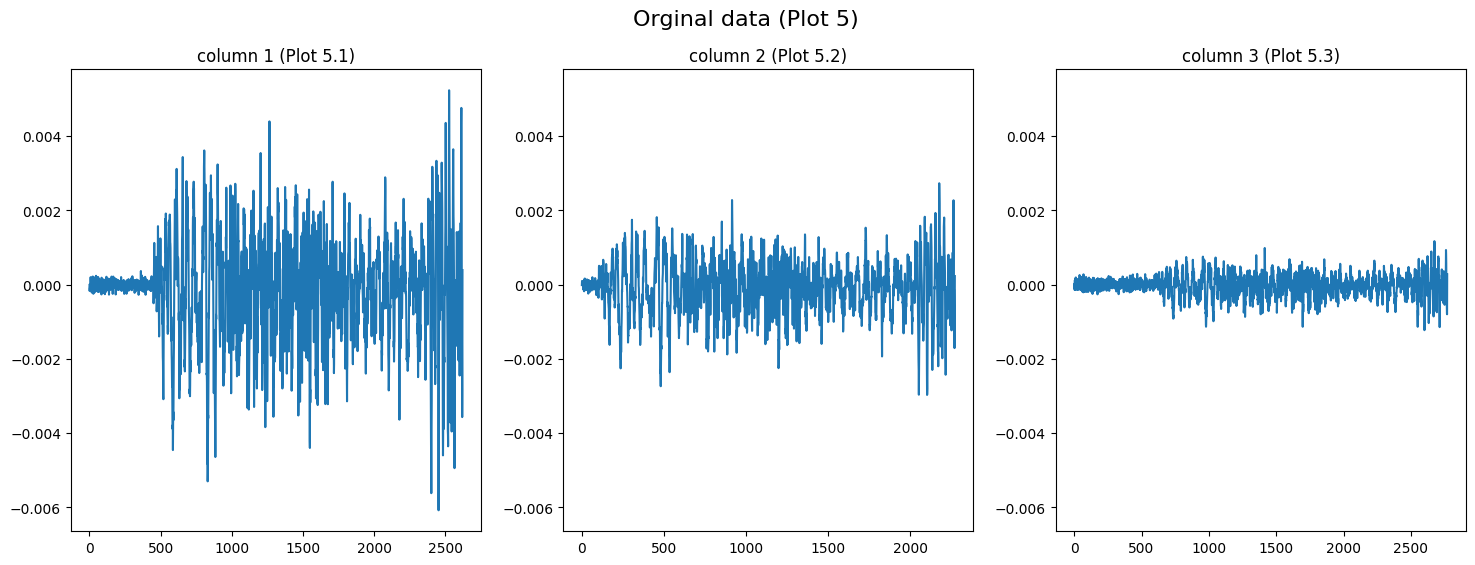

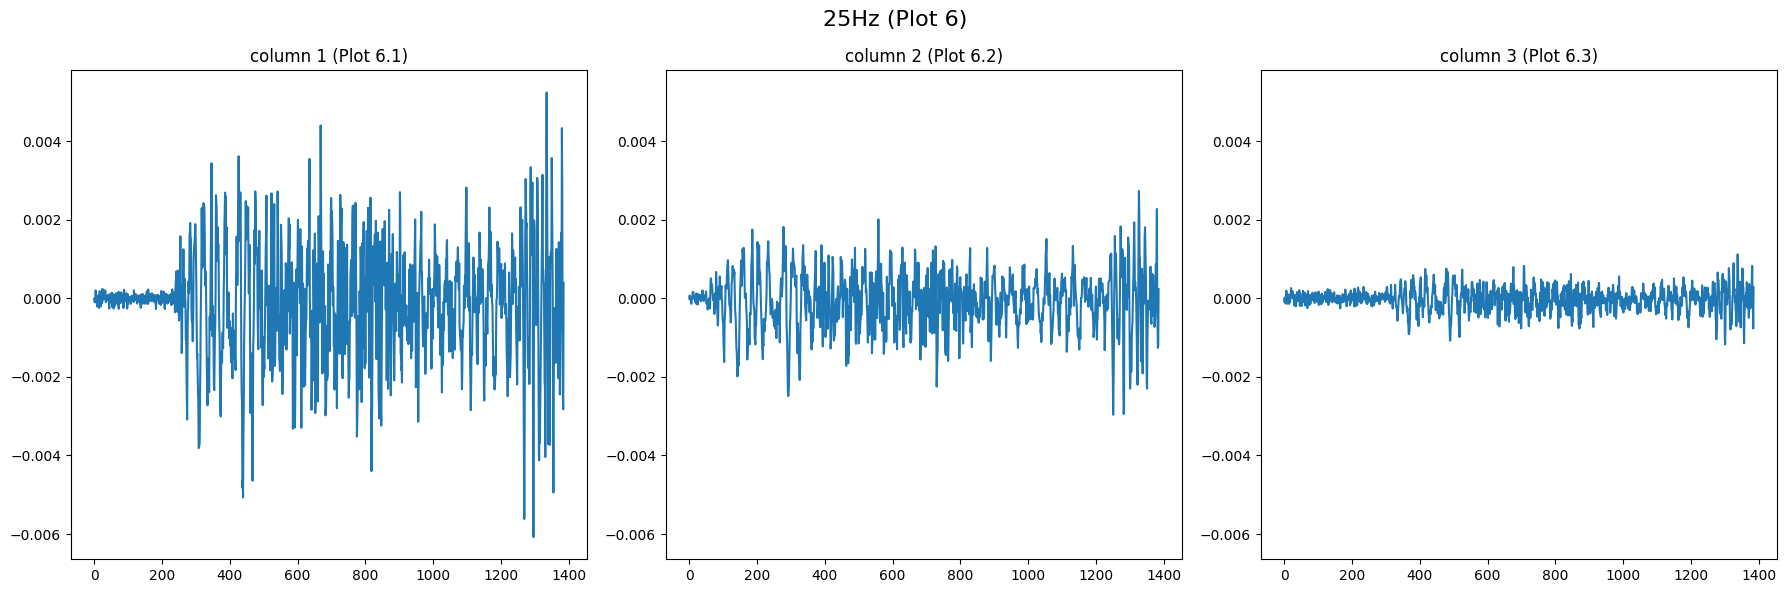

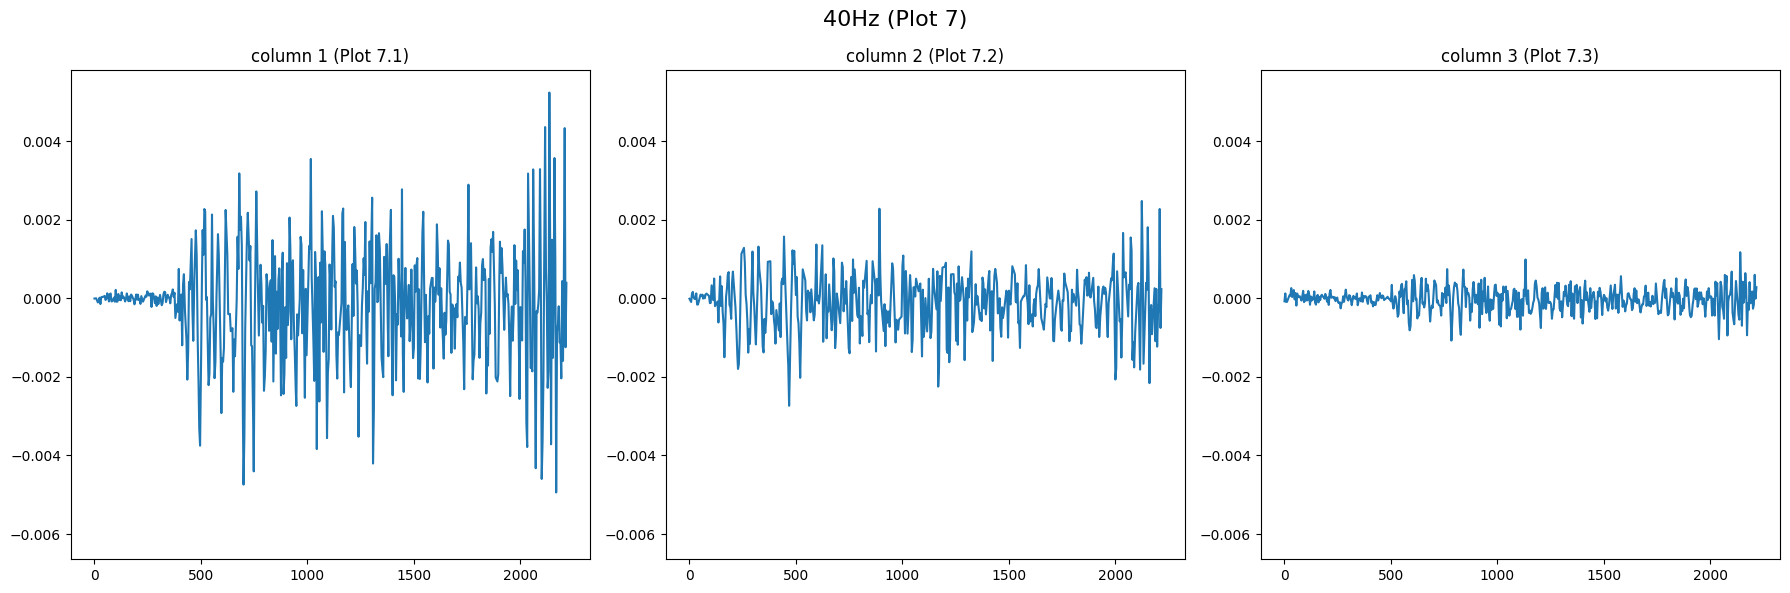

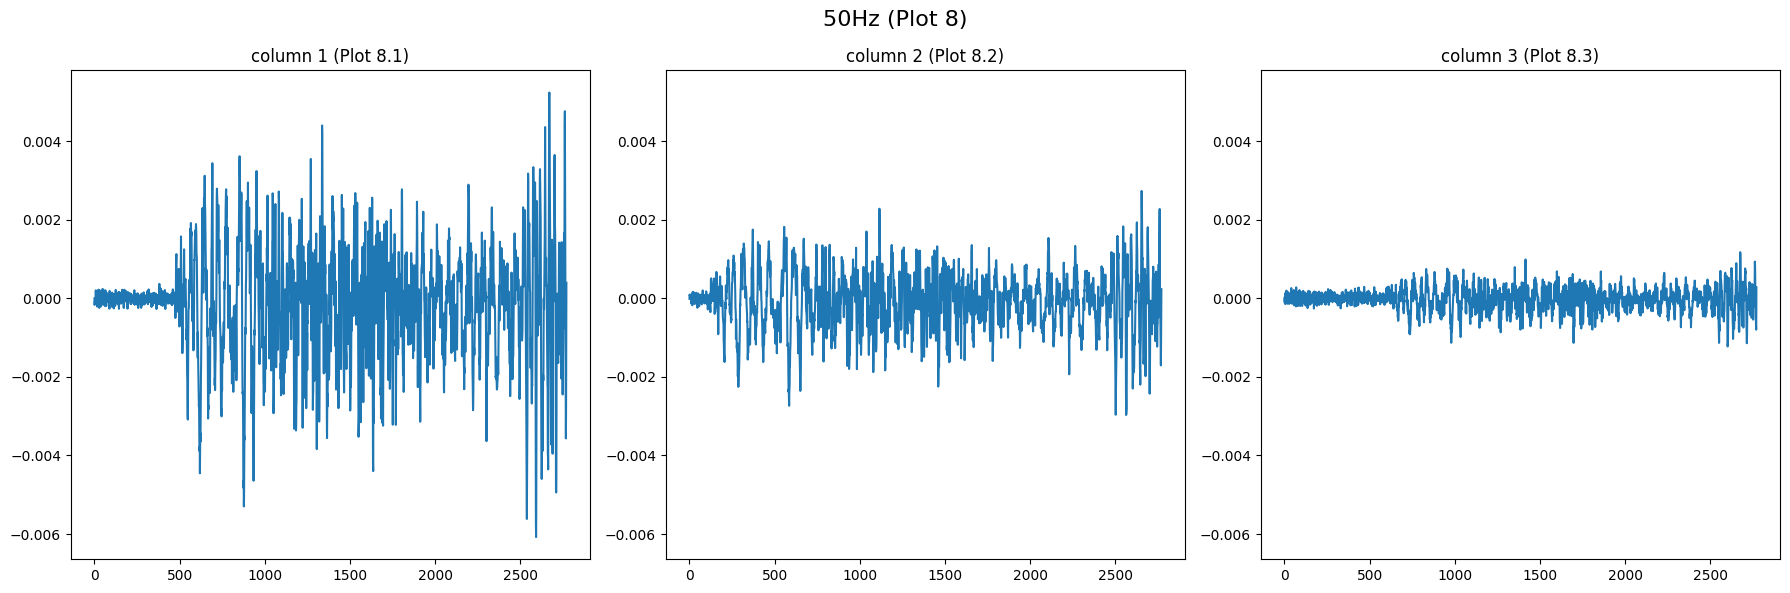

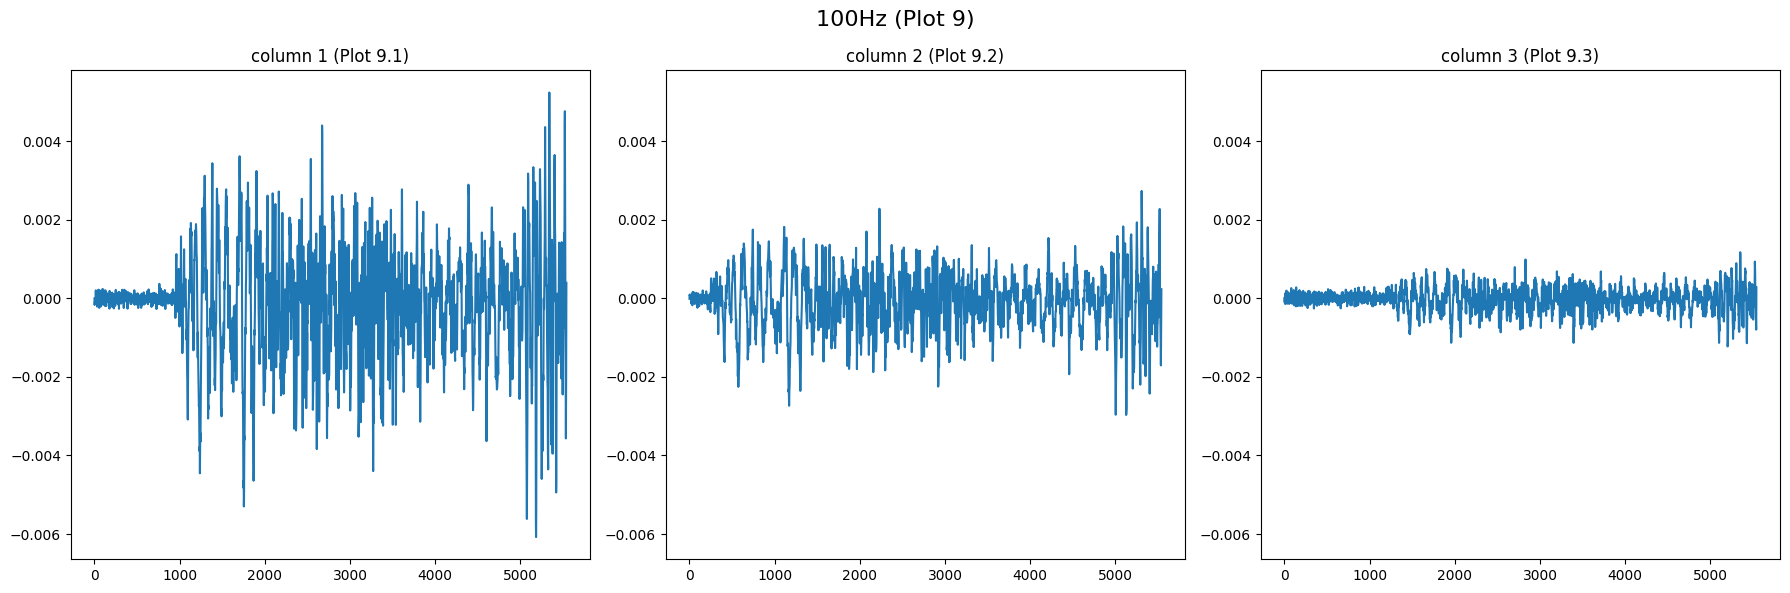

In [13]:
fig1, axs1 = plt.subplots(1, df.shape[1], figsize=(6 * df.shape[1], 6))
# For each column in the DataFrame
for i in range(df.shape[1]):
    # Plot the column before synchronisation
    axs1[i].plot(df.index, df.iloc[:, i])
    axs1[i].set_title(f'column {i+1} (Plot 5.{i+1})')
    axs1[i].set_ylim([ymin, ymax])
fig1.suptitle(f'Orginal data (Plot 5)', fontsize=16)

# Define the sampling rates in Hz
sampling_rates = [25, 40, 50, 100]

# For each sampling rate
for j in range(len(sampling_rates)):
    rate = sampling_rates[j]
    # Calculate the sampling interval in milliseconds
    interval = int(1000 / rate)
    # Resample and interpolate the DataFrame
    resamp_df = new_df.resample(f'{interval}ms').asfreq().interpolate(method='linear')
    resamp_df = resamp_df.reset_index(drop=True)

    # Create a new figure for the plot
    fig, axs = plt.subplots(1, resamp_df.shape[1], figsize=(6 * resamp_df.shape[1], 6))

    # For each column in the DataFrame
    for i in range(resamp_df.shape[1]):
        # Plot the column after synchronisation
        axs[i].plot(resamp_df.index, resamp_df.iloc[:, i])
        axs[i].set_title(f'column {i+1} (Plot {j+6}.{i+1})')
        axs[i].set_ylim([ymin, ymax])

    # Set a title for the entire figure
    fig.suptitle(f'{rate}Hz (Plot {j+6})', fontsize=16)

    plt.tight_layout()
    plt.show()